**hidden_size:** Number of neurons in the hidden layer, determining the model's capacity.

**meta_epochs:** Total number of meta-training iterations over the tasks.

**meta_batch_size:** Number of tasks sampled per meta-update (outer loop iteration).

**inner_lr:** Learning rate used for task-specific (inner loop) gradient updates.

**inner_steps:** Number of gradient descent steps taken in the inner loop for each task.

**num_support:** Number of support data points per task for model adaptation.

**num_query:** Number of query data points per task to evaluate performance and compute meta-loss.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class SimpleNet(nn.Module):
    def __init__(self, hidden_size=64):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

Define a functional forward pass (to allow parameter updates), generate sine tasks, and implement the inner-loop adaptation

In [6]:
def functional_forward(x, params):
    x = torch.nn.functional.linear(x, params[0], params[1])
    x = torch.relu(x)
    x = torch.nn.functional.linear(x, params[2], params[3])
    return x

def generate_sine_task(num_support=10, num_query=25):
    amplitude = torch.rand(1) * 5.0
    phase = torch.rand(1) * np.pi
    sine_fn = lambda x: amplitude * torch.sin(x - phase)
    support_x = (torch.rand(num_support, 1) * 10) - 5
    query_x   = (torch.rand(num_query, 1) * 10) - 5
    support_y = sine_fn(support_x)
    query_y   = sine_fn(query_x)
    return support_x.float(), support_y.float(), query_x.float(), query_y.float()

def inner_adaptation(model, support_x, support_y, inner_lr=0.01, inner_steps=5):
    adapted_params = list(model.parameters())
    for _ in range(inner_steps):
        preds = functional_forward(support_x, adapted_params)
        loss = nn.functional.mse_loss(preds, support_y)
        grads = torch.autograd.grad(loss, adapted_params, create_graph=True)
        adapted_params = [p - inner_lr * g for p, g in zip(adapted_params, grads)]
    return adapted_params


Implement the outer-loop meta-training process where multiple tasks are sampled, adapted, and used to update the model's initialization

In [7]:
def meta_train(model, meta_optimizer, meta_epochs=1000, meta_batch_size=10, inner_lr=0.01, inner_steps=5):
    for epoch in range(meta_epochs):
        meta_loss = 0.0
        for _ in range(meta_batch_size):
            support_x, support_y, query_x, query_y = generate_sine_task()
            adapted_params = inner_adaptation(model, support_x, support_y, inner_lr, inner_steps)
            query_preds = functional_forward(query_x, adapted_params)
            meta_loss += nn.functional.mse_loss(query_preds, query_y)
        meta_loss /= meta_batch_size
        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{meta_epochs}, Meta Loss: {meta_loss.item():.4f}")


Helper functions to plot sorted sine curves, visualize training tasks, and test the meta-trained model on a new task

In [8]:
def plot_sorted_line(x, y, style='k-', label=None):
    x_flat = x.squeeze()
    y_flat = y.squeeze()
    x_sorted, idx = torch.sort(x_flat)
    y_sorted = y_flat[idx]
    plt.plot(x_sorted.numpy(), y_sorted.numpy(), style, label=label)

def visualize_training_tasks(num_tasks=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_tasks):
        support_x, support_y, query_x, query_y = generate_sine_task()
        plt.subplot(1, num_tasks, i + 1)
        plot_sorted_line(query_x, query_y, 'k-', label='True Sine')
        plt.scatter(support_x.numpy(), support_y.numpy(), color='green', s=20, label='Support')
        plt.title(f"Task {i+1}")
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()

def test_meta(model, inner_lr=0.01, inner_steps=5):
    support_x, support_y, query_x, query_y = generate_sine_task()
    current_params = list(model.parameters())
    preds_list = []
    support_losses = []

    with torch.no_grad():
        initial_preds = functional_forward(query_x, current_params)
    preds_list.append(initial_preds)
    support_losses.append(nn.functional.mse_loss(functional_forward(support_x, current_params), support_y).item())

    for step in range(inner_steps):
        loss_support = nn.functional.mse_loss(functional_forward(support_x, current_params), support_y)
        grads = torch.autograd.grad(loss_support, current_params, create_graph=False)
        current_params = [p - inner_lr * g for p, g in zip(current_params, grads)]
        with torch.no_grad():
            pred_query = functional_forward(query_x, current_params)
        preds_list.append(pred_query)
        support_losses.append(nn.functional.mse_loss(functional_forward(support_x, current_params), support_y).item())

    plt.figure(figsize=(15, 3))
    for i, preds in enumerate(preds_list):
        plt.subplot(1, len(preds_list), i+1)
        plot_sorted_line(query_x, query_y, 'k-', label='True Sine')
        plt.scatter(support_x.numpy(), support_y.numpy(), color='green', s=20, label='Support')
        plot_sorted_line(query_x, preds, 'r--', label='Prediction')
        plt.title(f"Step {i}\nLoss={support_losses[i]:.4f}")
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()


Meta-train the model

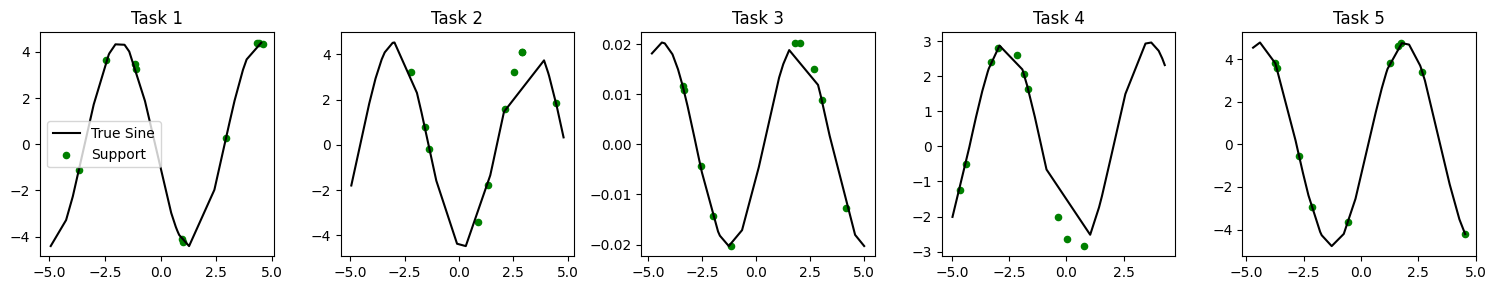

Epoch 100/1000, Meta Loss: 3.7803
Epoch 200/1000, Meta Loss: 3.0581
Epoch 300/1000, Meta Loss: 4.1633
Epoch 400/1000, Meta Loss: 3.3698
Epoch 500/1000, Meta Loss: 3.0972
Epoch 600/1000, Meta Loss: 3.2950
Epoch 700/1000, Meta Loss: 1.4865
Epoch 800/1000, Meta Loss: 2.2200
Epoch 900/1000, Meta Loss: 1.9511
Epoch 1000/1000, Meta Loss: 1.9382


In [10]:
torch.manual_seed(42)
visualize_training_tasks(num_tasks=5)

model = SimpleNet(hidden_size=64)
meta_optimizer = optim.Adam(model.parameters(), lr=0.001)

meta_train(model, meta_optimizer, meta_epochs=1000, meta_batch_size=10, inner_lr=0.01, inner_steps=5)

Test it on a new sine task

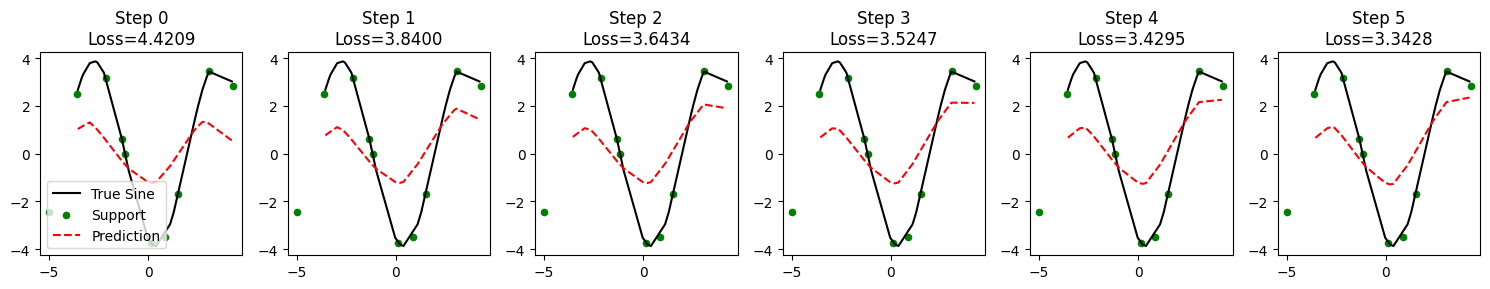

In [13]:
test_meta(model, inner_lr=0.01, inner_steps=5)